# DataONE Contributors

Examine the solr index to determine the number of contributors to content exposed by DataONE. The count provided here is likely higher than the actual number of contributors because the indexing process only performs minimal pre-processing of names added to the index. For example, in some cases names appear with both ASCII and Unicode variants and are treated as separate.

In [5]:
import requests
import json
import pprint
from datetime import datetime
import dateutil
import nameparser

SOLR_TIME_FORMAT = "%Y-%m-%dT%H:%M:%SZ"

T_NOW = datetime.utcnow()
T_START = datetime(2012,7,1)

# provides a map from a solr entry to a more normalized form
contributor_index = {}

In [6]:
def normalize_name(name):
    def strip_str(s):
        return s.strip(' :.,;()')
        
    parsed = nameparser.HumanName(name)
    initial = strip_str(parsed.middle).upper()
    if len(initial) > 1:
        initial = initial[0]
    given = strip_str(parsed.first).upper()
    if len(given) > 2:
        given = given[:3]
    return f"{strip_str(parsed.last).upper()}_{given}_{initial}"

def getContributors(t_start=None, t_end=None):
    url = "https://cn.dataone.org/cn/v2/query/solr/"
    params = {
        "q":"*:*",
        "facet":"on",
        "rows":"0",
        "facet.limit":"-1",
        "facet.field":"investigator",
        "wt":"json",
             }
    dq = None
    if t_start is not None:
        st = f"{t_start:{SOLR_TIME_FORMAT}}"
        if t_end is None:
            dq = f"dateUploaded:[\"{st}\" TO \"{T_NOW}\"]"
        else:
            dq = f"dateUploaded:[\"{st}\" TO \"{t_end:{SOLR_TIME_FORMAT}}\"]"
    else:
        et = f"{t_end:{SOLR_TIME_FORMAT}}"
        dq = f"dateUploaded:[* TO \"{et}\"]"
    if dq is not None:
        params["q"] = dq
    response = requests.get(url, params=params)
    data = json.loads(response.text)
    investigators = data["facet_counts"]["facet_fields"]["investigator"]
    names = []
    counts = []
    unames = {}
    for i in range(0, len(investigators), 2):
        if investigators[i] not in contributor_index:
            contributor_index[investigators[i]] = normalize_name(investigators[i])
        #print(f"{investigators[i]} : {contributor_index[investigators[i]]}")
        n = investigators[i+1]
        if n > 0:
            names.append(investigators[i])
            counts.append(investigators[i+1])
            nname = contributor_index[investigators[i]]
            unames[nname] = unames.get(nname,0) + n
    return names, counts, unames



In [7]:
c_date = T_START
name_count = []
columns = ["date","contributors","unique"]
print(",".join(columns))
while c_date < T_NOW:
    names, counts, unames = getContributors(t_end = c_date)
    entry = (c_date, len(names), len(unames.keys()))
    print(f"{entry[0]:%Y-%m-%d},{entry[1]},{entry[2]}")
    name_count.append(entry)
    c_date = c_date + dateutil.relativedelta.relativedelta(months=+1)


date,contributors,unique
2012-07-01,10676,9304
2012-08-01,11835,10446
2012-09-01,12310,10888
2012-10-01,12722,11270
2012-11-01,13501,12006
2012-12-01,14083,12546
2013-01-01,14532,12952
2013-02-01,15344,13710
2013-03-01,16189,14505
2013-04-01,16865,15129
2013-05-01,17419,15623
2013-06-01,18375,16520
2013-07-01,19018,17130
2013-08-01,19658,17715
2013-09-01,20428,18430
2013-10-01,21421,19322
2013-11-01,22167,20033
2013-12-01,22831,20622
2014-01-01,23401,21162
2014-02-01,24338,21993
2014-03-01,25228,22782
2014-04-01,26032,23532
2014-05-01,26900,24350
2014-06-01,27628,25038
2014-07-01,28565,25882
2014-08-01,29560,26826
2014-09-01,30231,27452
2014-10-01,31694,28824
2014-11-01,32790,29856
2014-12-01,34659,31610
2015-01-01,36014,32878
2015-02-01,37110,33893
2015-03-01,38396,34970
2015-04-01,39941,36428
2015-05-01,41454,37838
2015-06-01,42865,39138
2015-07-01,44358,40544
2015-08-01,45758,41840
2015-09-01,47004,43004
2015-10-01,48472,44357
2015-11-01,49924,45713
2015-12-01,51176,46853
2016-01-01

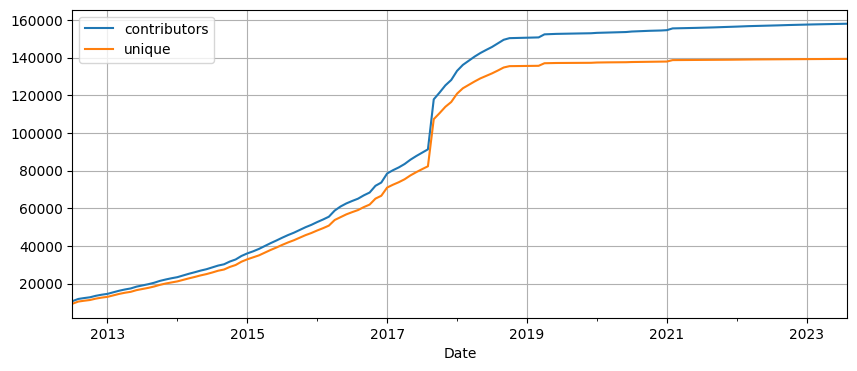

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
data_frame = pd.DataFrame(name_count, columns=columns)
data_frame.set_index('date', inplace=True)

plot = data_frame.plot(figsize=(10,4))
plot.set_xlabel("Date")
plot.grid(True)